In [14]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

In [15]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_16073/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [16]:
from mvpa2.datasets.mri import fmri_dataset

In [17]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

In [18]:
from nilearn.masking import unmask

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.


Version 5 uses scikit-learn directly, bypassing mvpa2's framework altogether. We also implement a 'forced choice' scorer.

In [19]:
from visualization import visualize_corr
import mvpa2

In [20]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


## Load

In [21]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [22]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [23]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [24]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [25]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [26]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [27]:
from mvpa_sst_utils import *

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/mvpa_sst_utils.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown
/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [28]:
from sklearn.model_selection import LeaveOneGroupOut

In [29]:
def remove_selected_outliers_mvpa_tesq_study(
    ind_div_combined,
    show_plot=False,
    neural_measures = ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','TESQ_E_sum','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','cancer_promoting_minus_preventing_FFQ','bf_1'] + neural_measures,
    show_plot=show_plot)
    return(idc_outliers_removed)

In [30]:
from outlier_detection import *

In [31]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


In [32]:
from sklearn.model_selection import LeaveOneGroupOut

In [33]:
from generic_utils import *

## whole brain

Now let's scale that up to the full dataset.

## masks

We get the same file this time, but we apply a mask before doing learning.

In [21]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [22]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, error_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

Next to do:
1. Consider re-implementing LinearSVM and getting similarity rather than this probability measure
2. Visualize for all the other values.

Now we've decoupled the learner from the framework where we apply it, we can pass in any arbitrary learner. It just has to output:

1. predictions 
2. prediction confidence 
3. the classifier itself

### Re-implementing v3

This is a useful sanity check, becuase it's helpufl to try and explain why we're doing so much  better than rpeviously.

In [23]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [24]:
linear_results_with_similarity = do_forced_choice(
    Brain_Data_allsubs,
    get_predict_and_prob=do_LinearSVC)

.................................................................................

In [25]:
LinearSVC_correlation_wholebrain = linear_results_with_similarity

In [26]:
forced_choice_results = linear_results_with_similarity

In [27]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [28]:
(prediction, forced_choice_prediction)

(0.8518518518518519, 0.9876543209876543)

Formerly this was .85, .95, which was remarkable--we've now pretty clearly reproduced the result we were getting using nltools..

However, after I updated it based on documentation here (https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html) it performed less well. Not sure why the classifier is performing _less_ well in this setup than the former one - perhaps hte sort of normalization that I am doing on each side.

In [29]:
sample_wise_results = forced_choice_results['sample_wise']
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')


In [30]:
from outlier_detection import *



In [31]:
full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
    full_dataset_cs,
    neural_measures = ['pred_prob_CorrectStop'])

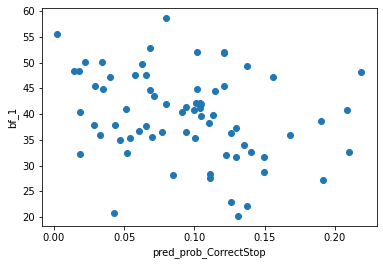

In [32]:
visualize_corr('pred_prob_CorrectStop','bf_1',full_dataset_cs)

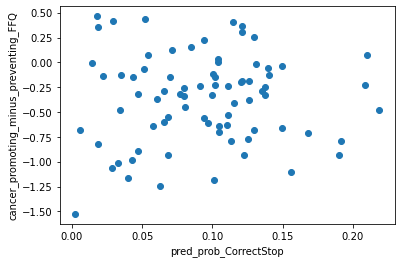

In [33]:
visualize_corr('pred_prob_CorrectStop','cancer_promoting_minus_preventing_FFQ',full_dataset_cs)

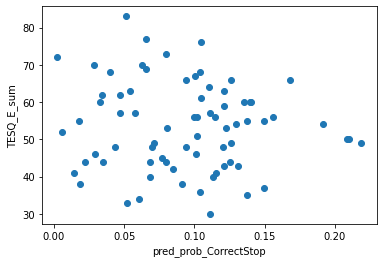

In [34]:
visualize_corr('pred_prob_CorrectStop','TESQ_E_sum',full_dataset_cs)

#### v3 mask

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7407407407407407 0.9629629629629629
executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7037037037037037 0.8641975308641975
response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6851851851851852 0.9753086419753086
inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6172839506172839 0.8765432098765432
harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6666666666666666 0.9135802469135802
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7098765432098766 0.9382716049382716
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.691358024691358 0.9012345679012346


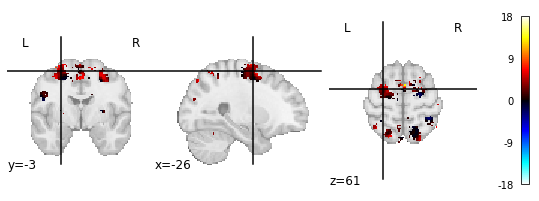

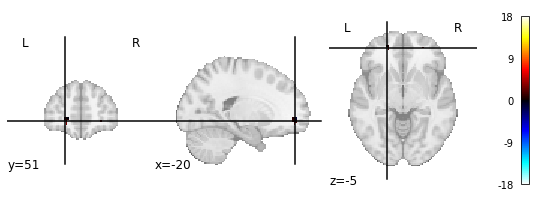

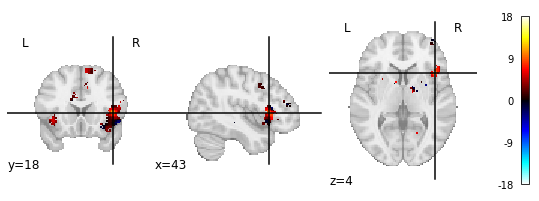

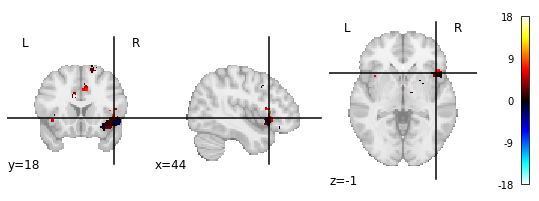

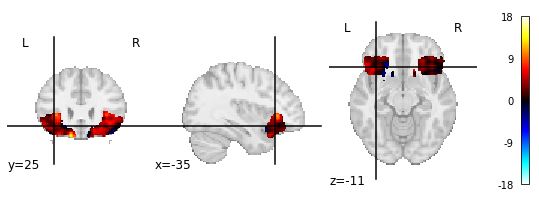

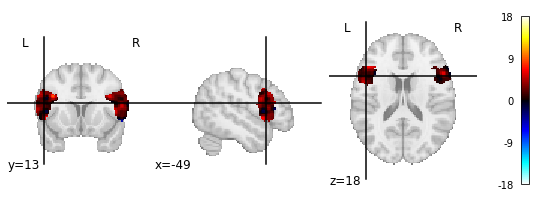

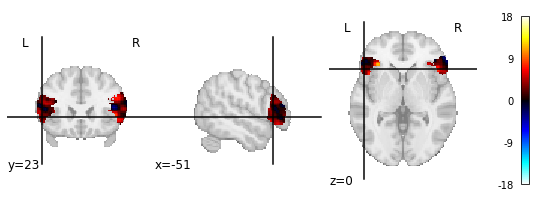

In [35]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

In [36]:
LinearSVC_correlation_masked = forced_choice_results_dict

planning_association-test_z_FDR_0.01
(0.7407407407407407, 0.9629629629629629)


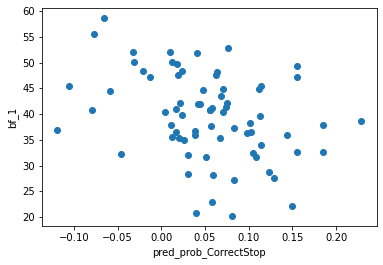

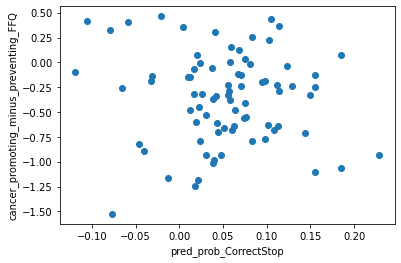

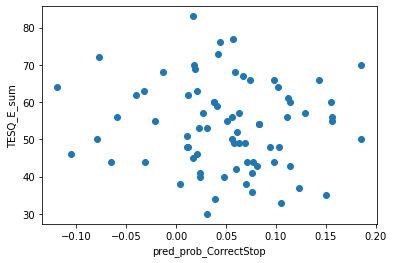

executive function_association-test_z_FDR_0.01
(0.7037037037037037, 0.8641975308641975)


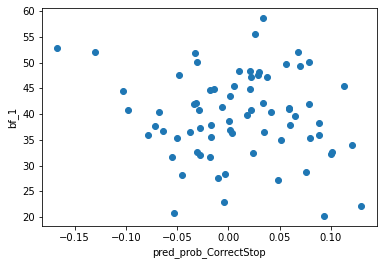

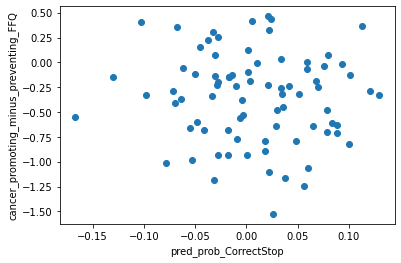

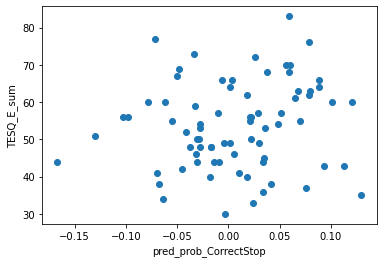

response inhibition_association-test_z_FDR_0.01
(0.6851851851851852, 0.9753086419753086)


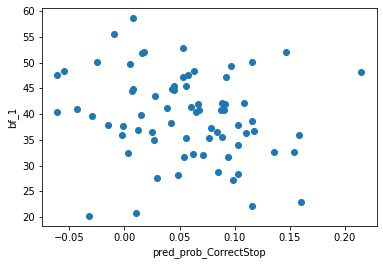

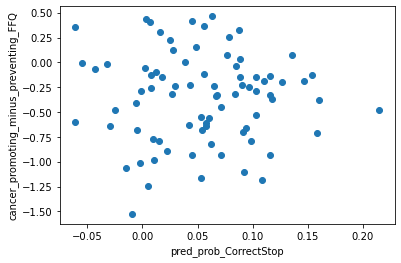

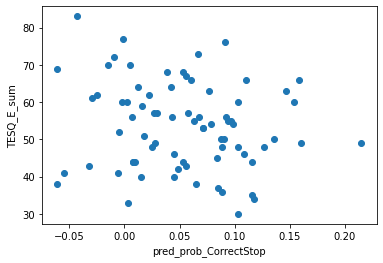

inhibition_association-test_z_FDR_0.01
(0.6172839506172839, 0.8765432098765432)


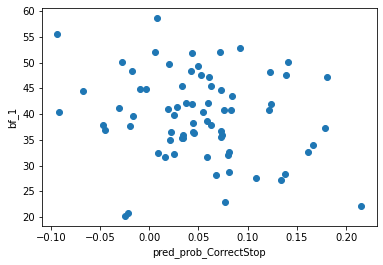

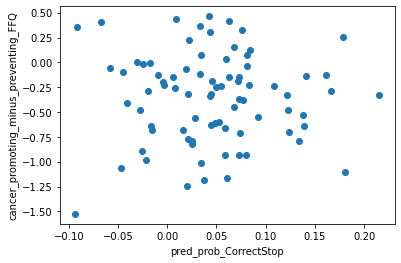

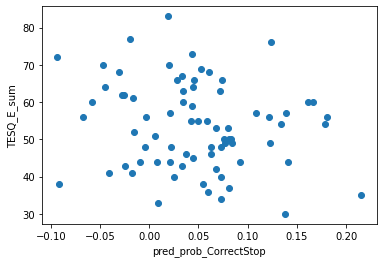

harvardoxford-cortical_prob_Frontal Orbital Cortex
(0.6666666666666666, 0.9135802469135802)


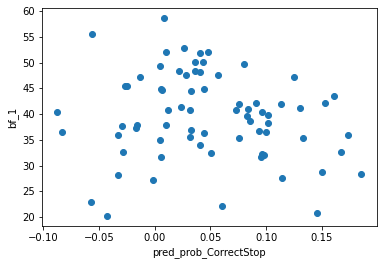

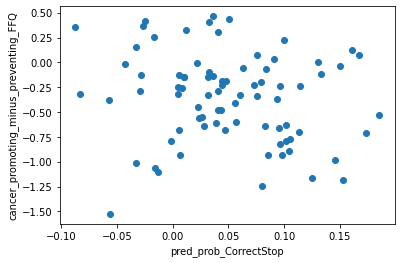

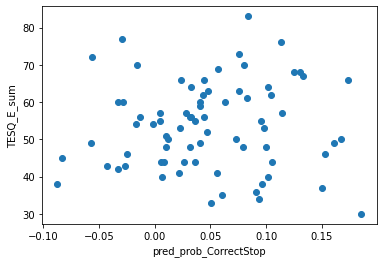

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
(0.7098765432098766, 0.9382716049382716)


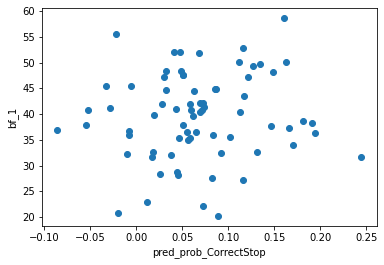

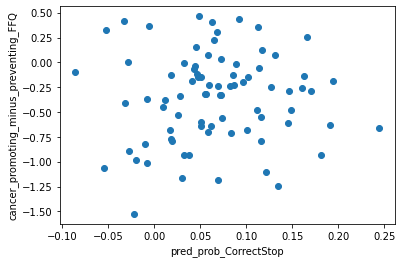

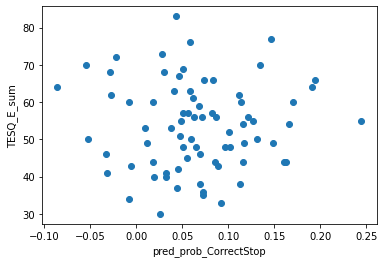

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
(0.691358024691358, 0.9012345679012346)


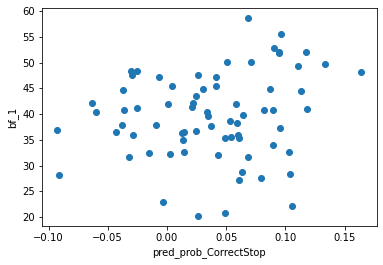

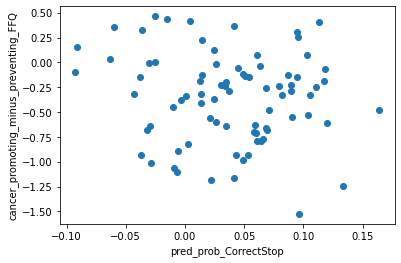

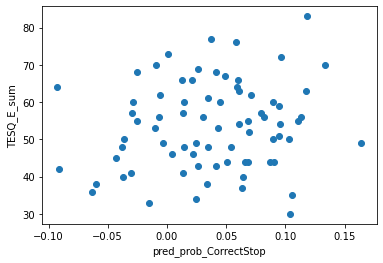

In [37]:
for k in forced_choice_results_dict.keys():
    v=forced_choice_results_dict[k]
    print(k)
    print_forced_choice_results(v,individual_differences,['pred_prob_CorrectStop'])

## Apply the main analysis, looping through masks

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


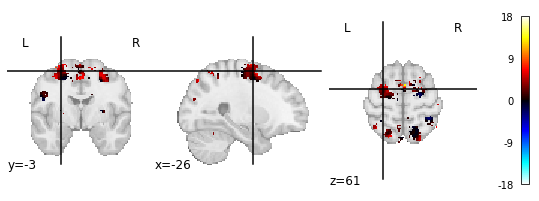

.................................................................................
0.9320987654320988 0.9876543209876543
(0.9320987654320988, 0.9876543209876543)


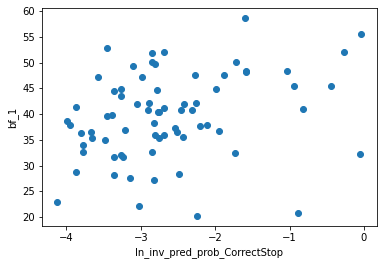

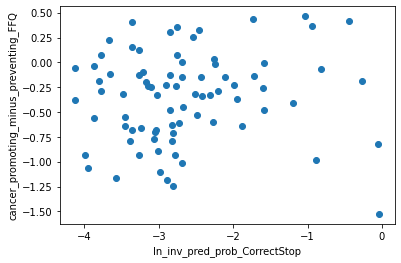

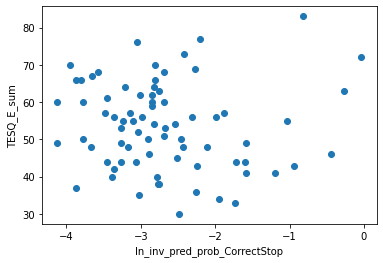

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


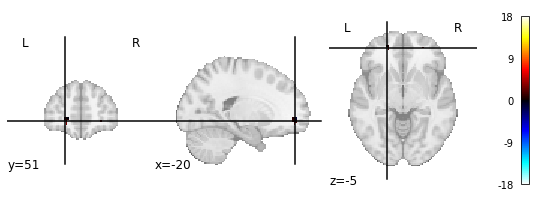

.................................................................................
0.9135802469135802 0.9753086419753086
(0.9135802469135802, 0.9753086419753086)


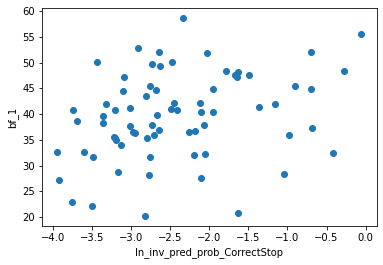

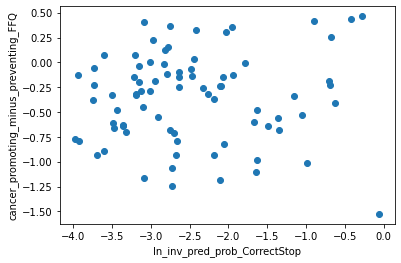

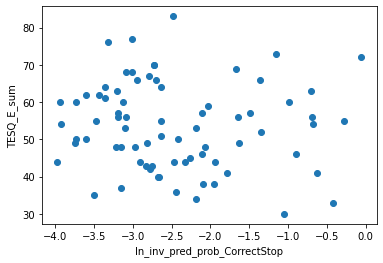

response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


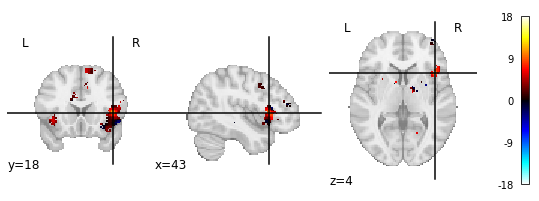

.................................................................................
0.9382716049382716 0.9753086419753086
(0.9382716049382716, 0.9753086419753086)


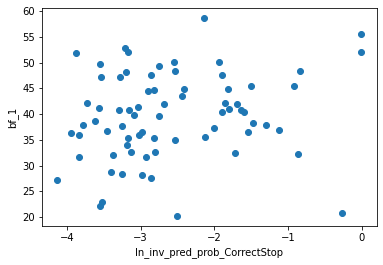

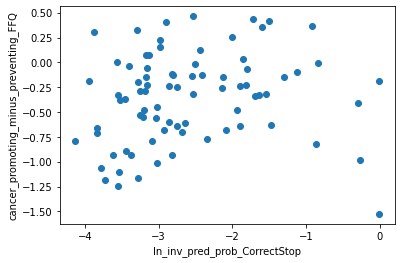

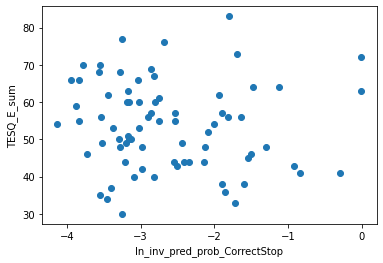

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


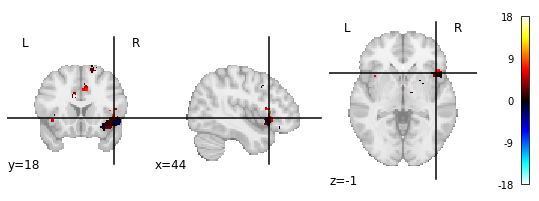

.................................................................................
0.9259259259259259 0.9753086419753086
(0.9259259259259259, 0.9753086419753086)


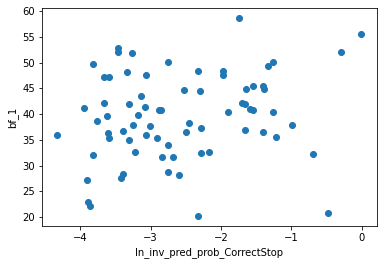

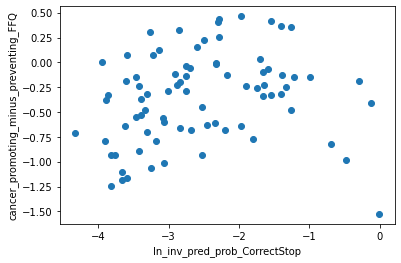

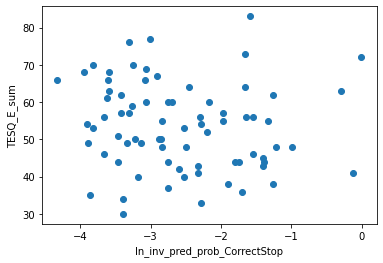

harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


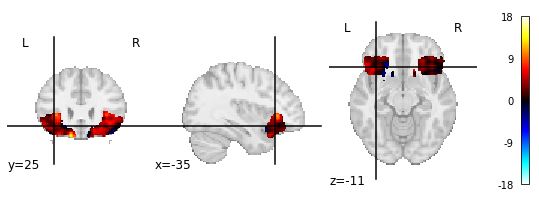

.................................................................................
0.9506172839506173 0.9753086419753086
(0.9506172839506173, 0.9753086419753086)


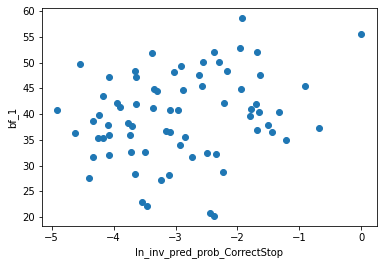

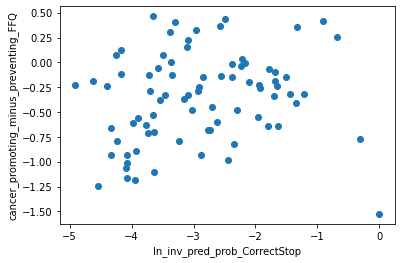

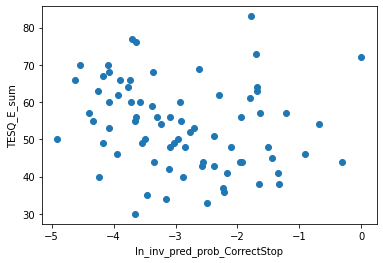

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


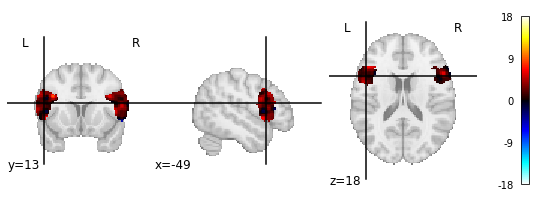

.................................................................................
0.9320987654320988 0.9753086419753086
(0.9320987654320988, 0.9753086419753086)


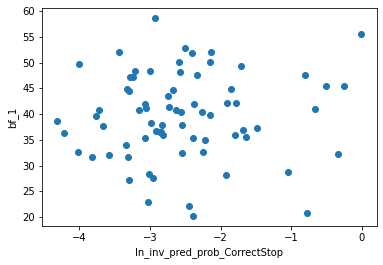

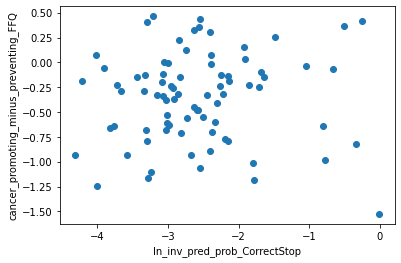

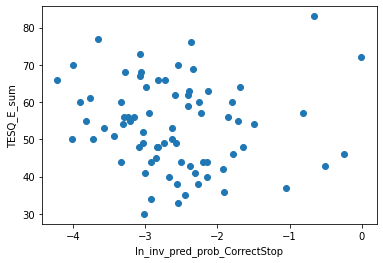

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


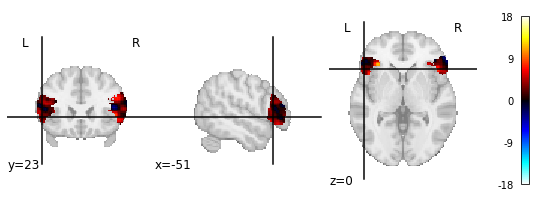

.................................................................................
0.9444444444444444 0.9753086419753086
(0.9444444444444444, 0.9753086419753086)


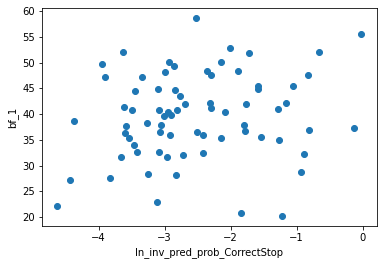

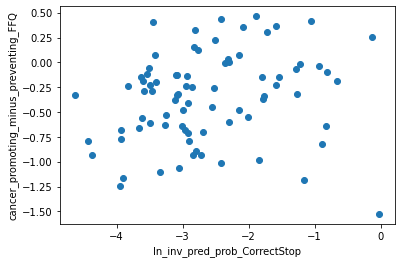

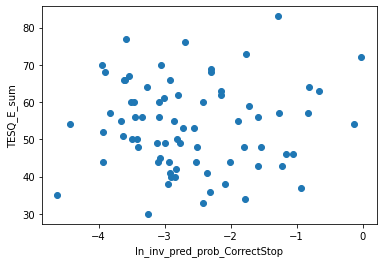

In [38]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(forced_choice_results,individual_differences,['ln_inv_pred_prob_CorrectStop'])

In [39]:
SVC_proba_masked = forced_choice_results_dict

whole brain
127427.37037037036
.................................................................................0.9506172839506173 0.9876543209876543
(0.9506172839506173, 0.9876543209876543)


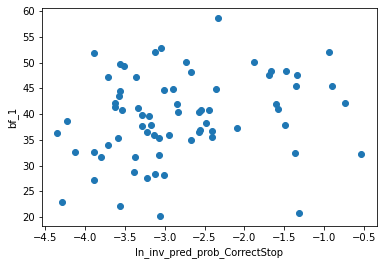

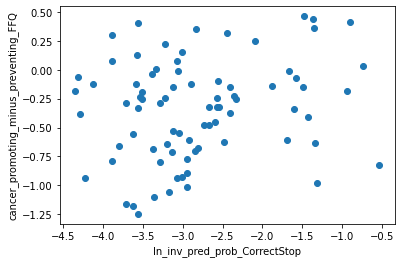

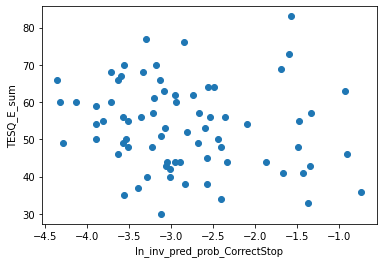

In [40]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
print_forced_choice_results(forced_choice_results,individual_differences,['ln_inv_pred_prob_CorrectStop'])

In [41]:
SVC_proba_wholebrain = forced_choice_results

## Contrast between CorrectStop and CorrectGo...

In [42]:
def print_regression_results(forced_choice_results, neural_measures = ['mae']):
    sample_wise_results = forced_choice_results['sample_wise']
#    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(sample_wise_results,how='outer',left_on='subj_wave',right_on='chunks')
    print(full_dataset_cs.columns)
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
        full_dataset_cs,neural_measures = neural_measures,
        show_plot=False)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

planning_association-test_z_FDR_0.01
1685.1518987341772


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


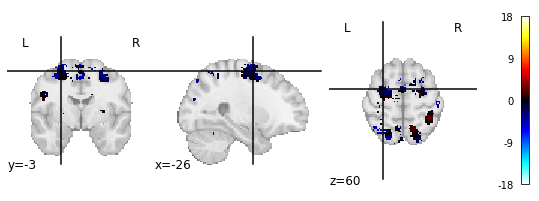

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


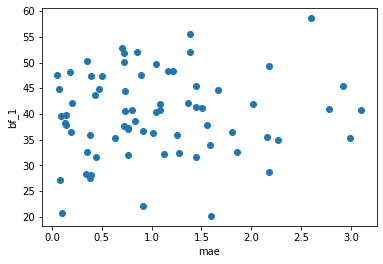

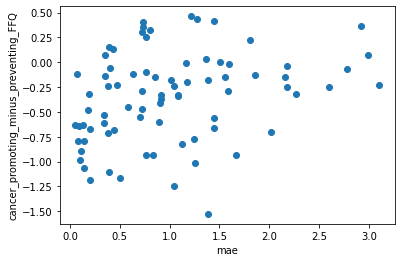

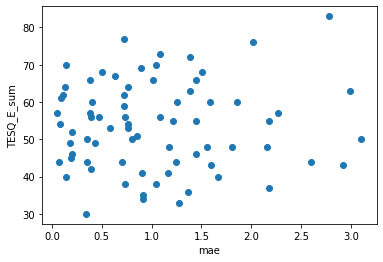

executive function_association-test_z_FDR_0.01
77.50632911392405


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


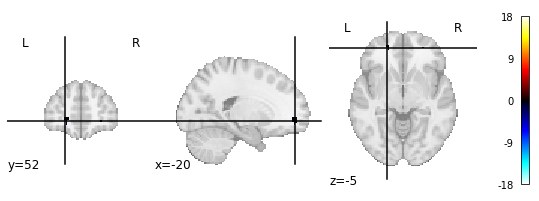

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


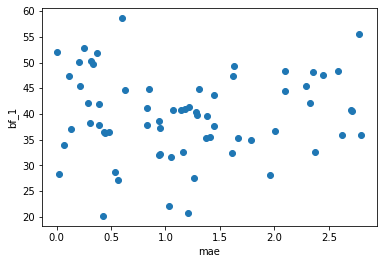

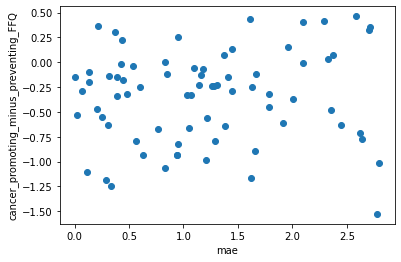

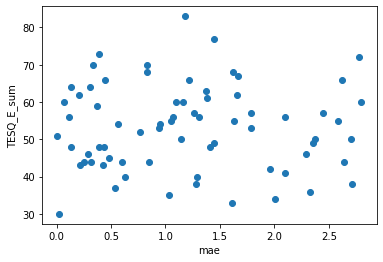

response inhibition_association-test_z_FDR_0.01
1291.1645569620252


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


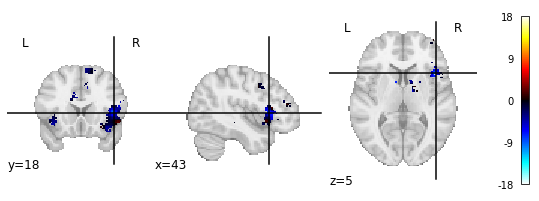

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


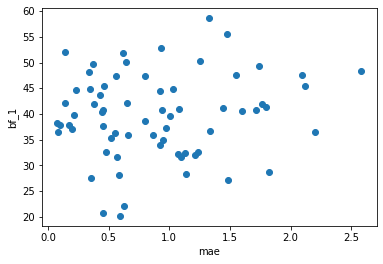

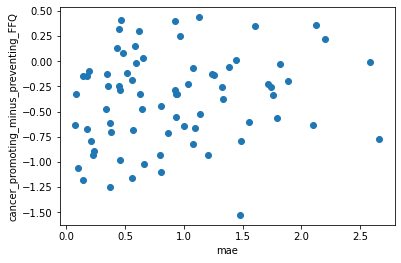

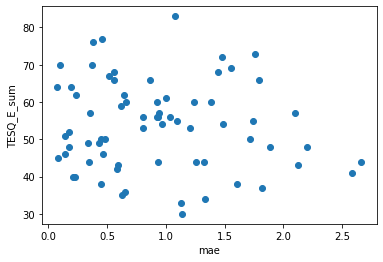

inhibition_association-test_z_FDR_0.01
436.0886075949367


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


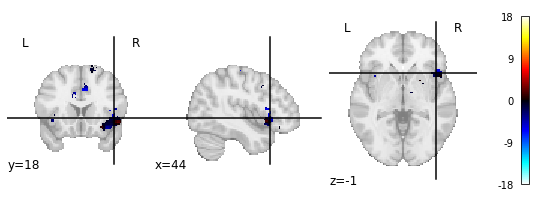

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


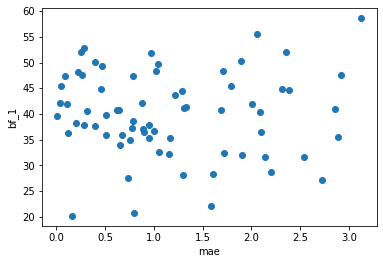

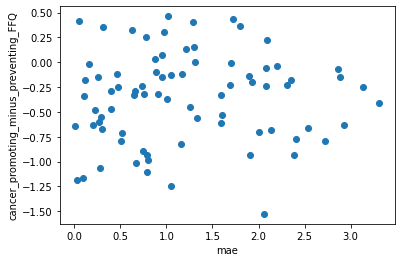

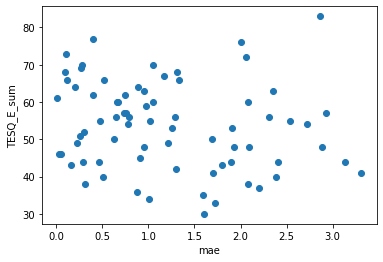

harvardoxford-cortical_prob_Frontal Orbital Cortex
2847.012658227848


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


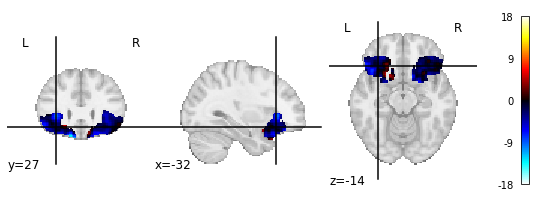

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


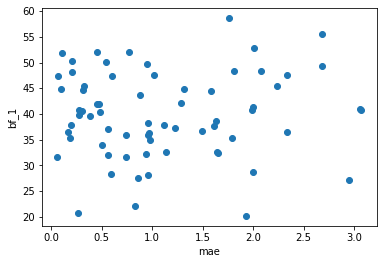

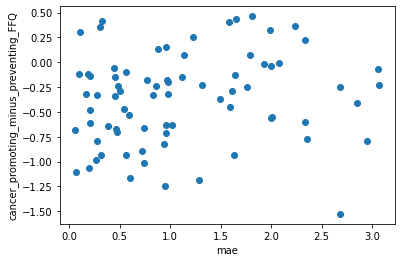

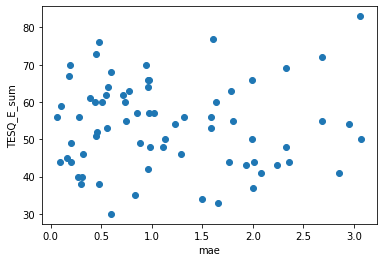

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
1471.4303797468353


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


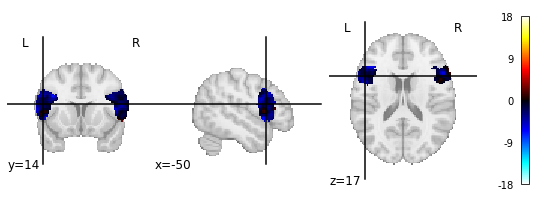

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


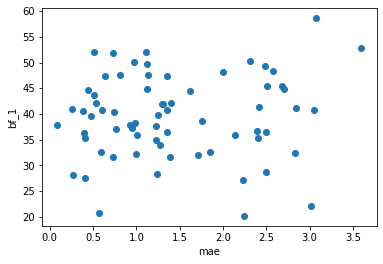

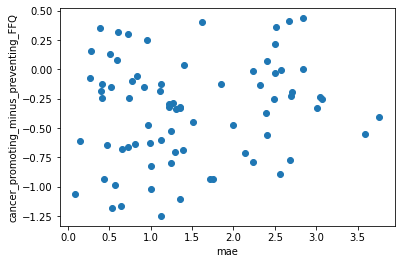

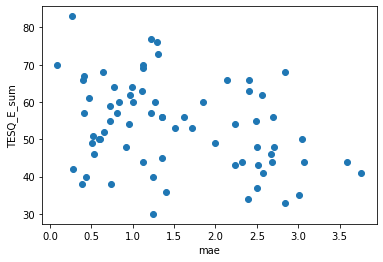

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
1538.620253164557


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


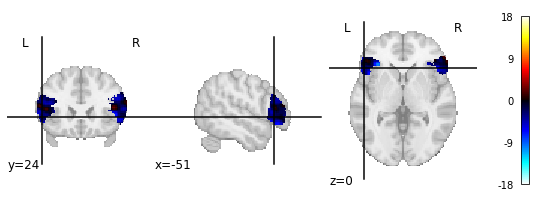

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


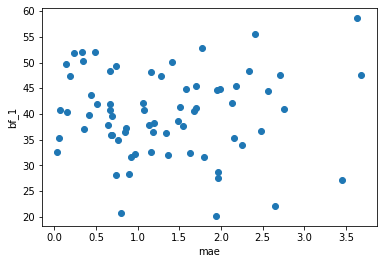

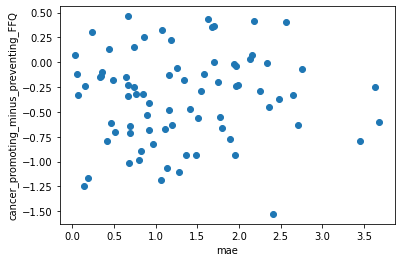

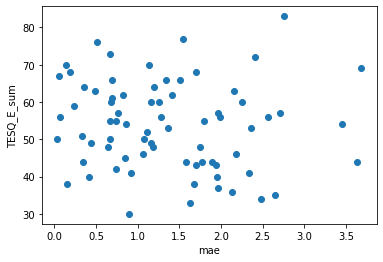

In [43]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):

        target='SST_SSRT'

        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)

        Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
        print("")


        forced_choice_results_dict[mask_name]=forced_choice_results
        print_regression_results(forced_choice_results,['mae'])
        
mae_predictivity_masked = forced_choice_results_dict

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
108520.02531645569


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


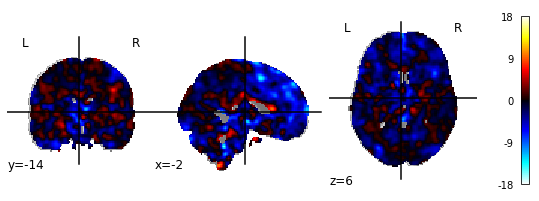

..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3466e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.55211e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27406e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.11435e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.01995e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22174e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1365e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29197e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.37195e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14587e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3401e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4792e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.13074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.51638e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.10771e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42884e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16605e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24135e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27849e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.17444e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.51536e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.03639e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.32662e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.47439e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.263e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14526e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24325e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.36e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.33944e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41993e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16458e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16236e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27412e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.81581e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41303e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29131e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22977e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.99843e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.44902e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.88395e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.28041e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1843e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.78835e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16703e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.57511e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42558e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4367e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.63866e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.40746e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.23091e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29997e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22218e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.05825e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.30593e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.46081e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24517e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.43528e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.99017e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1692e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41775e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22715e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.34319e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.15753e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.10879e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24447e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27121e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22157e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27406e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.06374e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.056e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.48659e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.05474e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16402e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22216e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14187e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29135e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.13431e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.32289e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)



Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.00275e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


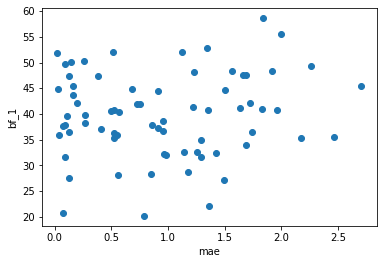

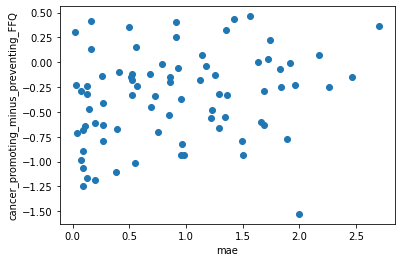

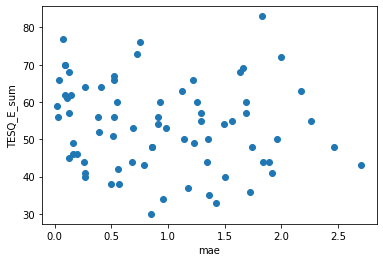

In [44]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast.pkl"
)

target='SST_SSRT'

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

print(mask_name)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(masked_preview,vmax=18)
plotting.show()
forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
print("")


forced_choice_results_dict[mask_name]=forced_choice_results
print_regression_results(forced_choice_results,['mae'])

In [45]:
mae_predictivity_wholebrain = forced_choice_results

## Test 2

In [68]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

In [69]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


So actually, probably neural activity explains additional variance in a very straightforward way.

We found some relationships with FFQ. If these hold, it would be interesting to see support from them.

sooo...let's get a record of all the items from test 1 that we want to try running...

In [70]:
def select_CS_trials(df):
    return(df[df['target_y']=='CorrectStop'])

def select_CS_and_labels(df):
    return(df.loc[:,['chunks','pred_prob_CorrectStop']])

def label_cols(df, prepend):
    df1=df.copy()
    df1.columns = [prepend + c if c!="chunks" else c for c in df.columns]
    return(df1)

In [71]:
linearSVC_cor_wholebrain_CS_CS = label_cols(prepend="linearSVC_cor_wholebrain_CS_CS", df=select_CS_and_labels(select_CS_trials(LinearSVC_correlation_wholebrain['sample_wise'])))
linearSVC_cor_planning_CS_CS = label_cols(prepend="linearSVC_cor_planning_CS_CS", df=select_CS_and_labels(select_CS_trials(LinearSVC_correlation_masked['planning_association-test_z_FDR_0.01']['sample_wise'])))
SVC_prob_planning_CS_CS = label_cols(prepend="SVC_prob_planning_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['planning_association-test_z_FDR_0.01']['sample_wise'])))
SVC_prob_exec_function_CS_CS = label_cols(prepend="SVC_prob_exec_function_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['executive function_association-test_z_FDR_0.01']['sample_wise'])))
SVC_inhib_CS_CS = label_cols(prepend="SVC_inhib_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['inhibition_association-test_z_FDR_0.01']['sample_wise'])))
SVC_IFG_PT_CS_CS = label_cols(prepend="SVC_IFG_PT_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis']['sample_wise'])))
SVC_wholebrain_CS_CS = label_cols(prepend="SVC_wholebrain_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_wholebrain['sample_wise'])))

In [72]:
neural_all = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(
        linearSVC_cor_wholebrain_CS_CS,
        linearSVC_cor_planning_CS_CS),
        SVC_prob_planning_CS_CS),
        SVC_prob_exec_function_CS_CS),
        SVC_inhib_CS_CS),
        SVC_IFG_PT_CS_CS),
        SVC_wholebrain_CS_CS)

In [73]:
individual_differences['subj_wave'] = individual_differences.subject + "_" + individual_differences.wave.astype(str)

In [74]:
neural_behavioral = pd.merge(
    neural_all,
    individual_differences,
    left_on='chunks',right_on='subj_wave')



In [75]:
neural_behavioral.to_csv(ml_data_folderpath + "/analysis_v5_test1.csv")

In [76]:
ml_data_folderpath

'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml'

# PES-related

Discriminability

In [34]:
pes_vars_of_interest  =['RTFS_factor_1','RTFS_factor_2','RTFS_f1_minus_f2', 
                        'SST_PostErrorSlowW1_median','SST_PostErrorSlowW1_mean','SST_pes_mean_limited',
                        'FFQ_v2_Mean_Weighted_Nutrient_Density']

In [35]:

all_masks = get_failure_masks(ml_data_folderpath)

## PES-related conditions separate

whole-brain:

In [36]:
np.random.seed(1646100326)

In [24]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


whole brain
124651.33333333333
.................................................................................

(0.5308641975308642, 0.35802469135802467)


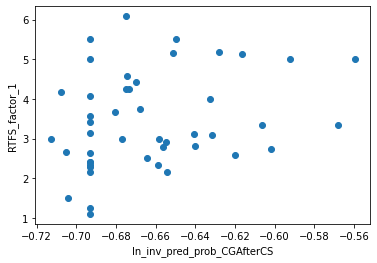

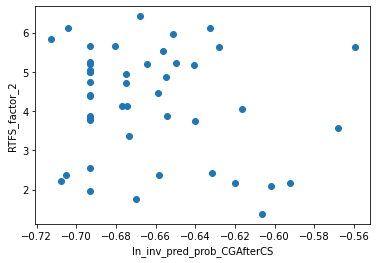

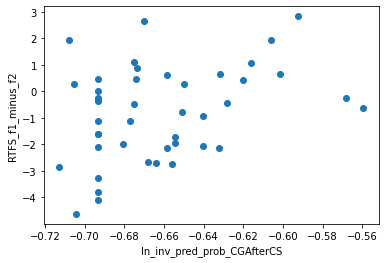

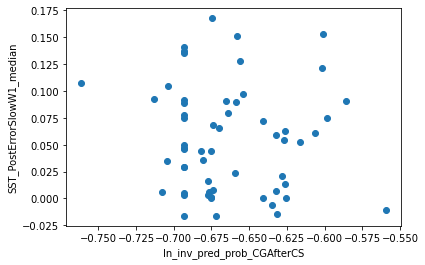

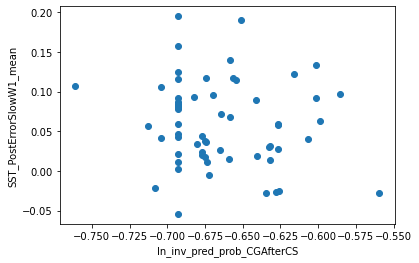

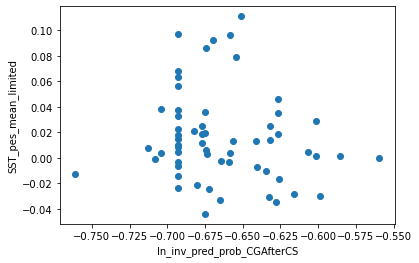

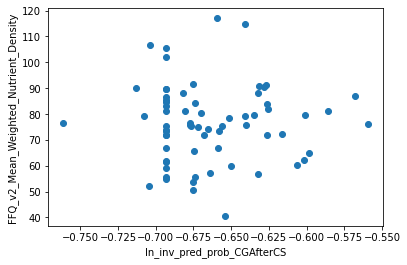

(0.5308641975308642, 0.35802469135802467)


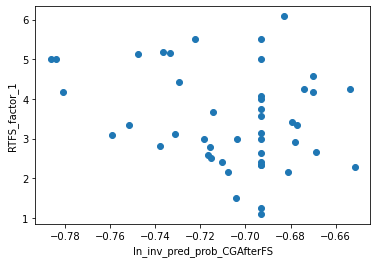

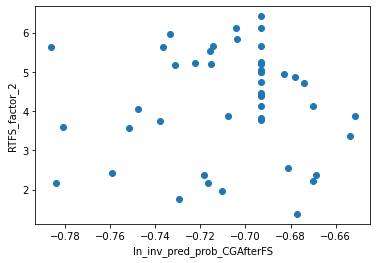

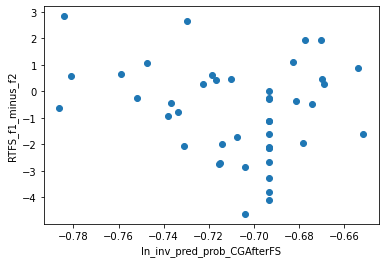

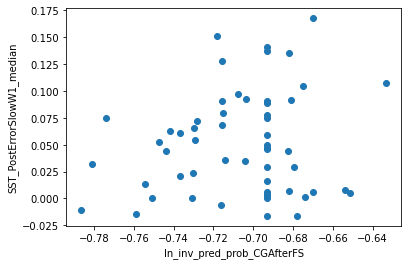

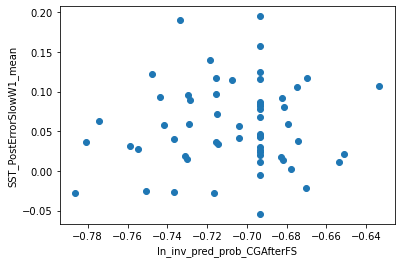

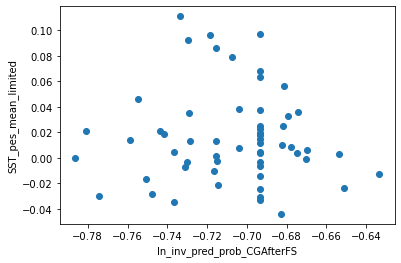

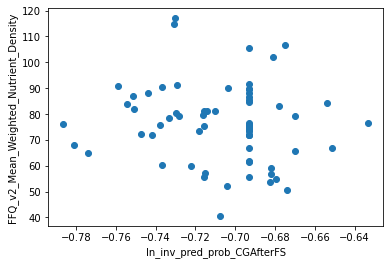

0.5308641975308642 0.35802469135802467


In [25]:

forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])


print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterCS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingCorrectStop')
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterFS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingFailedStop')

print(prediction,forced_choice_prediction)

whole brain
124651.33333333333
.................................................................................0.5308641975308642 0.35802469135802467
(0.5308641975308642, 0.35802469135802467)


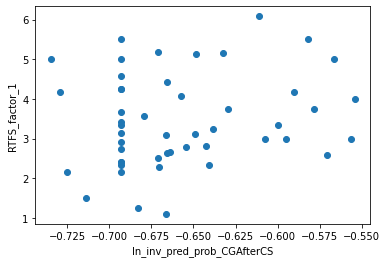

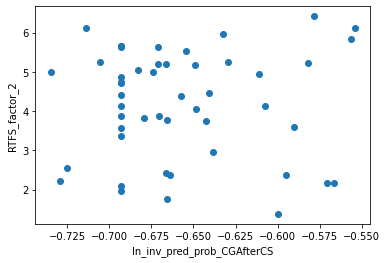

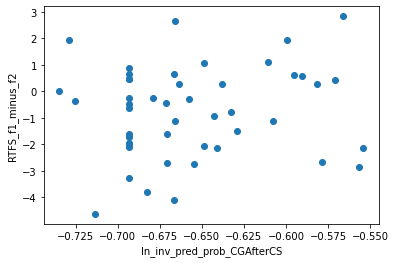

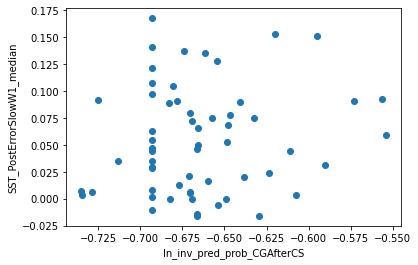

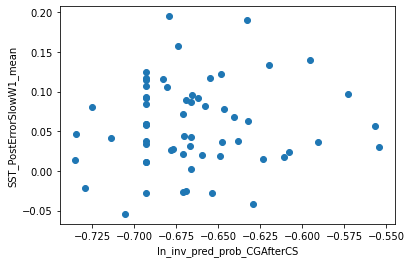

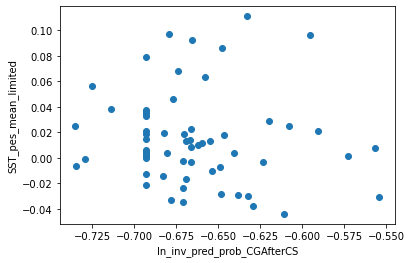

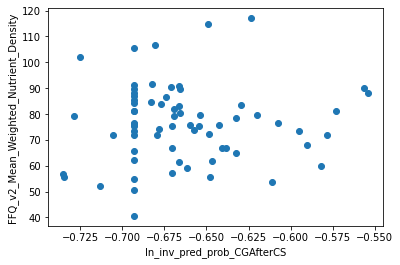

(0.5308641975308642, 0.35802469135802467)


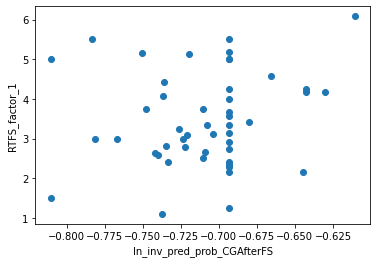

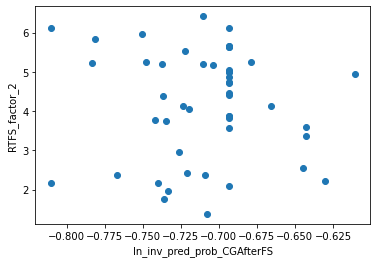

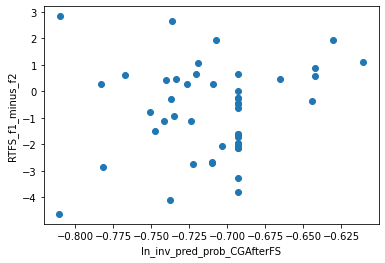

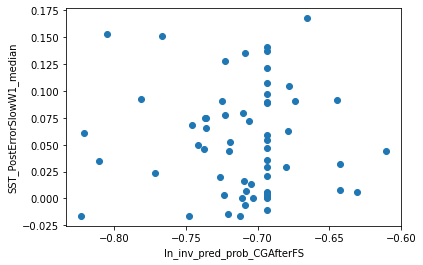

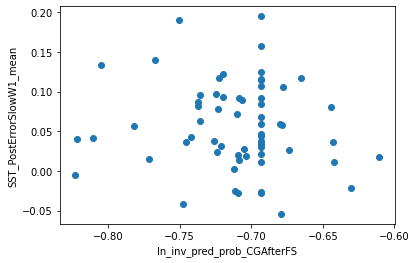

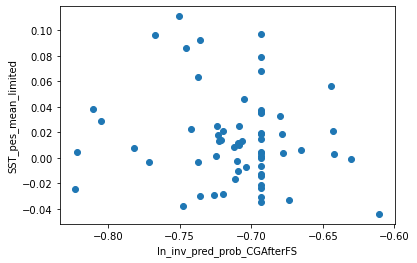

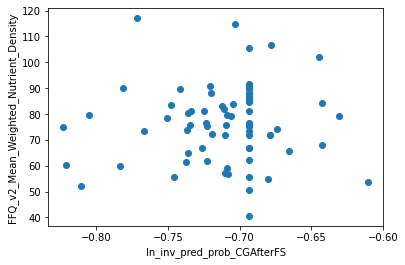

0.5308641975308642 0.35802469135802467


In [38]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

print(prediction,forced_choice_prediction)

print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterCS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingCorrectStop')
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterFS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingFailedStop')

print(prediction,forced_choice_prediction)

In [39]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGoFollowingCorrectStop,pred_prob_CorrectGoFollowingFailedStop,ln_inv_pred_prob_CGAfterCS,ln_inv_pred_prob_CGAfterFS
0,DEV005_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.491896,0.508104,-0.677069,-0.709488
1,DEV005_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.494236,0.505764,-0.681684,-0.704743
0,DEV006_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.493639,0.506361,-0.680504,-0.705952
1,DEV006_1,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,0.507756,0.492244,-0.708780,-0.677755
0,DEV010_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.461919,0.538081,-0.619745,-0.772367
...,...,...,...,...,...,...,...,...
1,DEV216_1,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,0.492047,0.507953,-0.677365,-0.709182
0,DEV217_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.432470,0.567530,-0.566461,-0.838243
1,DEV217_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.444805,0.555195,-0.588436,-0.810119
0,DEV218_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.500000,0.500000,-0.693147,-0.693147


In [28]:
SVC_proba_wholebrain = forced_choice_results

masked:

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative affect_association-test_z_FDR_0.01.pkl
negative affect_association-test_z_FDR_0.01
1209.0617283950617


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


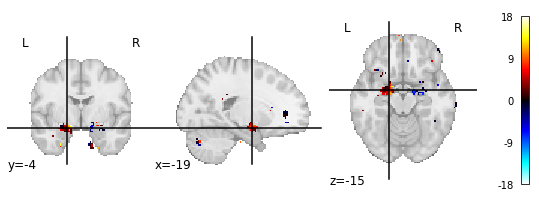

.................................................................................0.5 0.30864197530864196
(0.5, 0.30864197530864196)


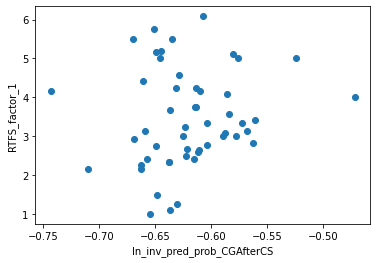

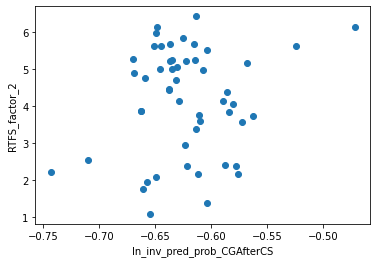

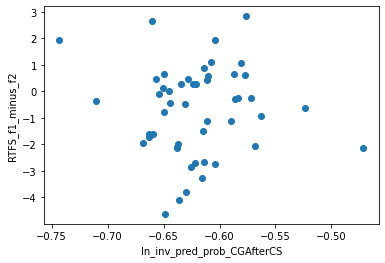

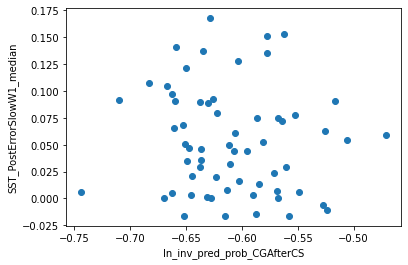

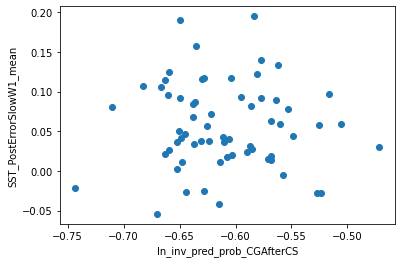

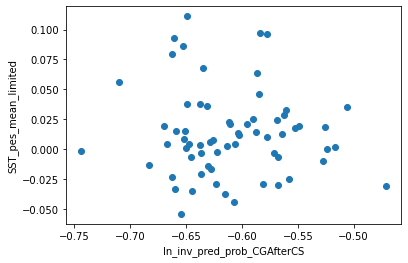

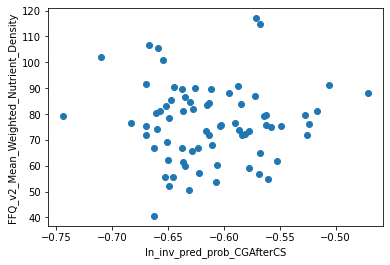

(0.5, 0.30864197530864196)


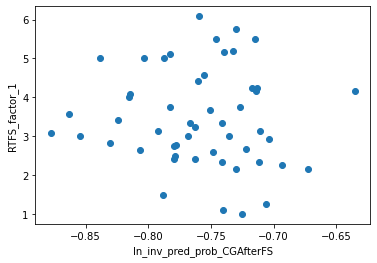

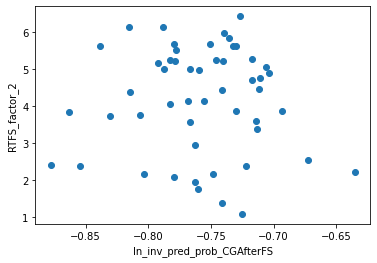

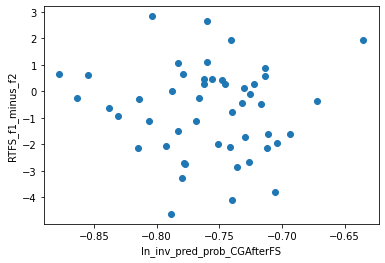

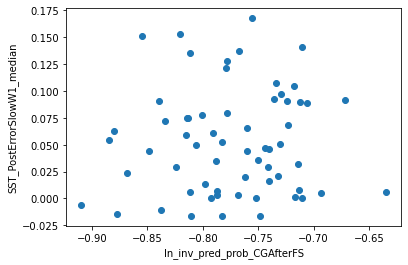

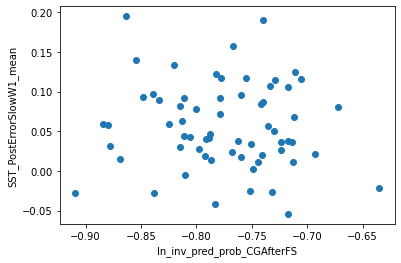

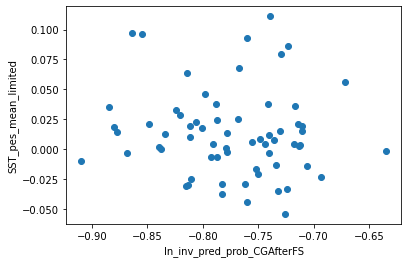

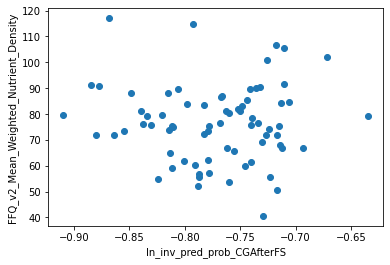

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_emotion regulation_association-test_z_FDR_0.01.pkl
emotion regulation_association-test_z_FDR_0.01
956.5493827160494


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


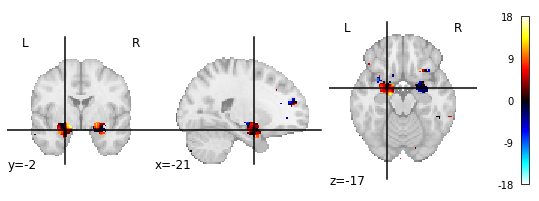

.................................................................................0.5061728395061729 0.32098765432098764
(0.5061728395061729, 0.32098765432098764)


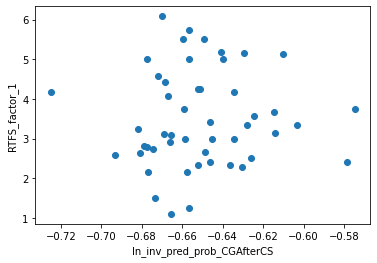

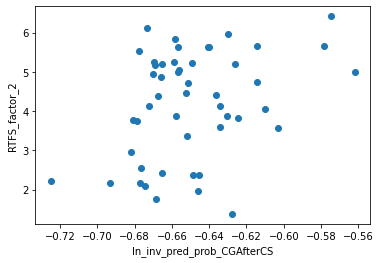

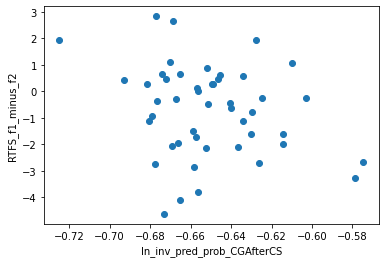

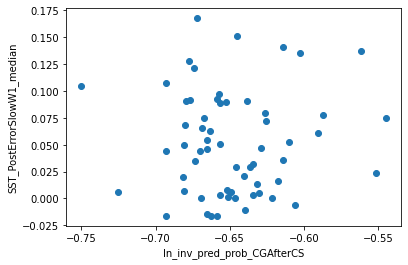

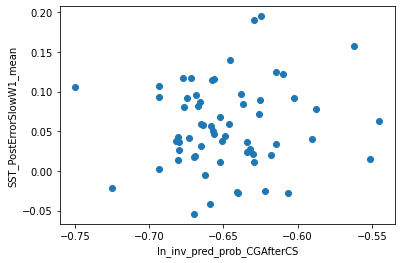

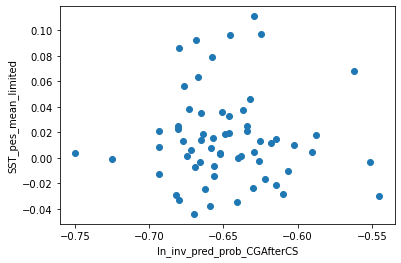

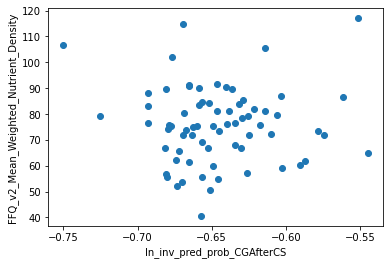

(0.5061728395061729, 0.32098765432098764)


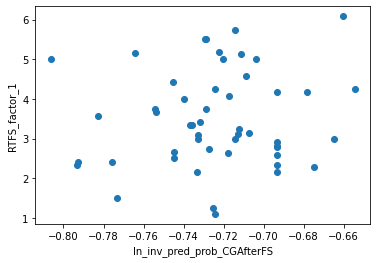

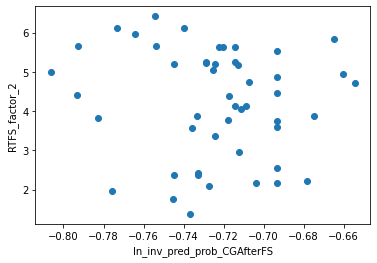

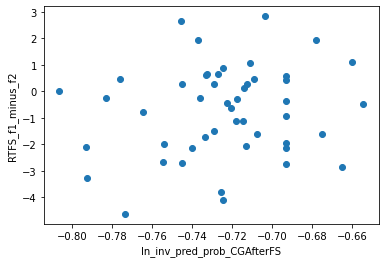

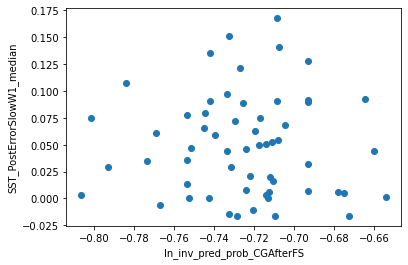

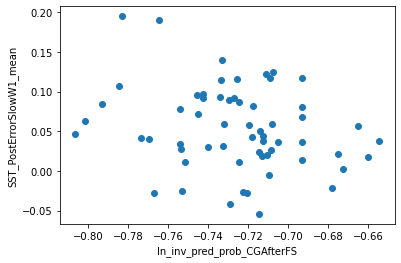

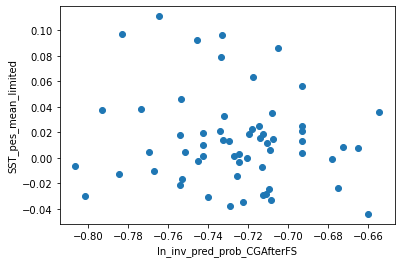

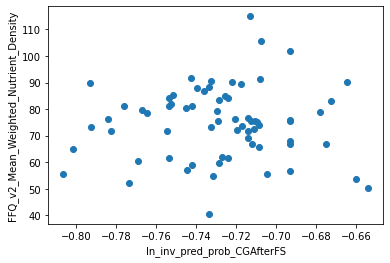

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Frontal Medial Cortex.pkl
harvardoxford-cortical_prob_Frontal Medial Cortex
1744.5


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


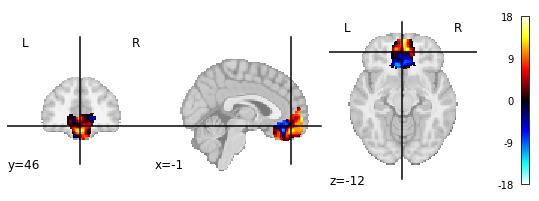

.................................................................................0.5 0.4444444444444444
(0.5, 0.4444444444444444)


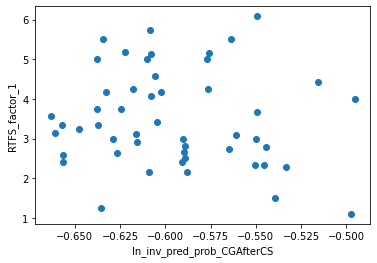

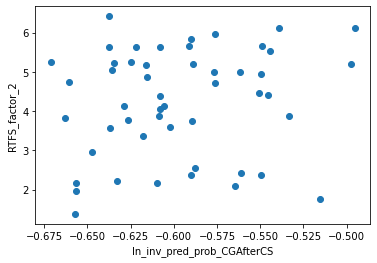

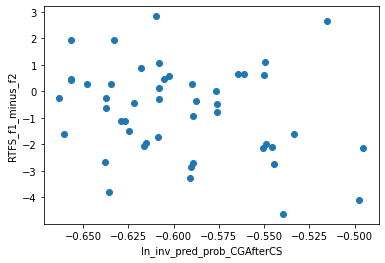

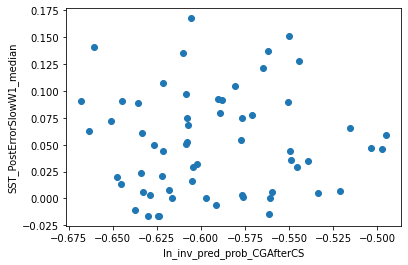

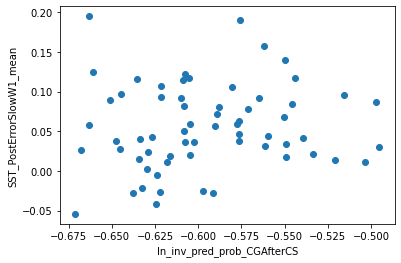

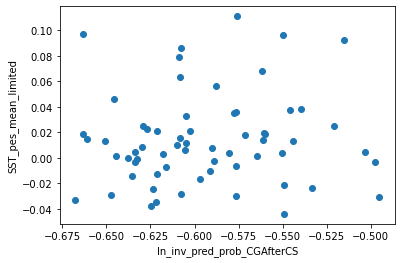

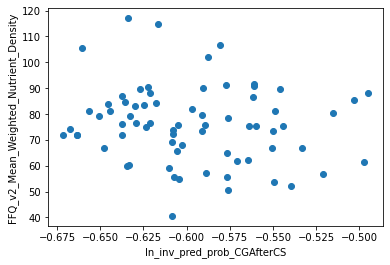

(0.5, 0.4444444444444444)


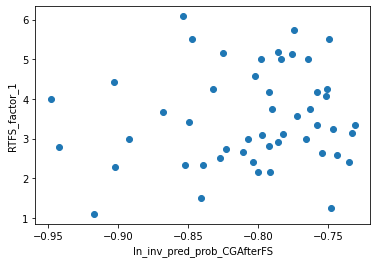

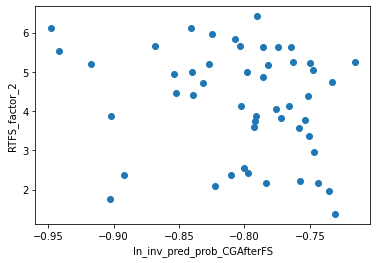

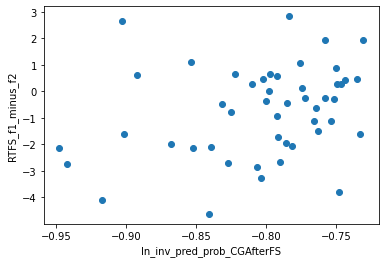

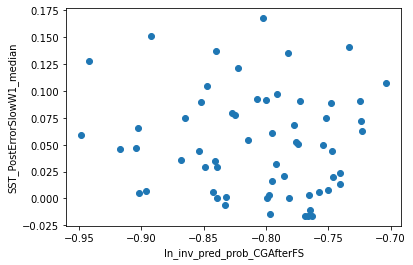

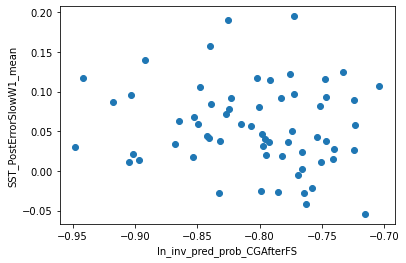

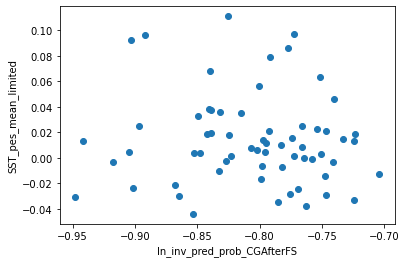

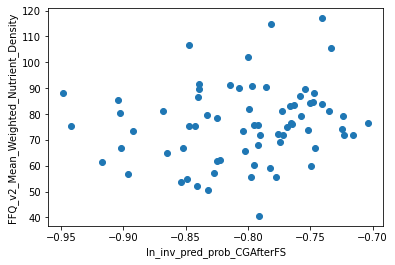

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative emotions_association-test_z_FDR_0.01.pkl
negative emotions_association-test_z_FDR_0.01
575.395061728395


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


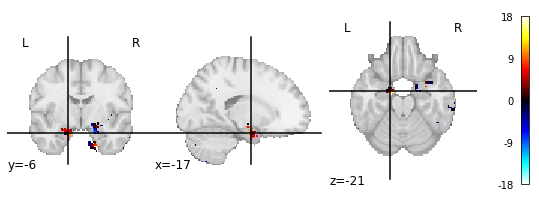

.................................................................................0.5 0.37037037037037035
(0.5, 0.37037037037037035)


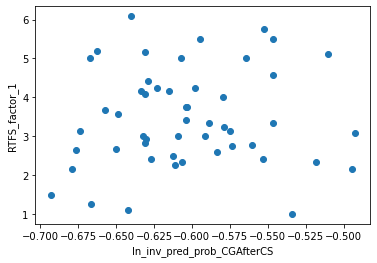

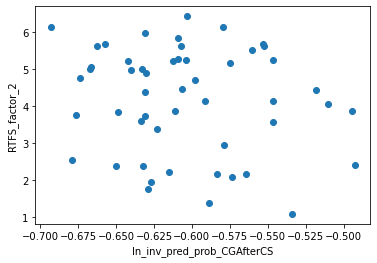

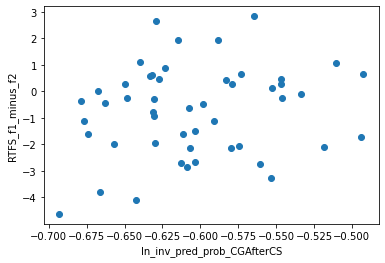

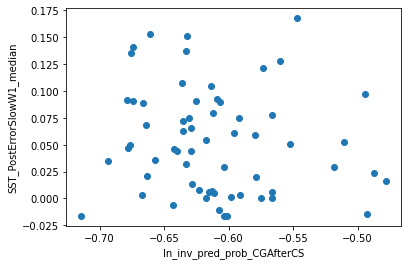

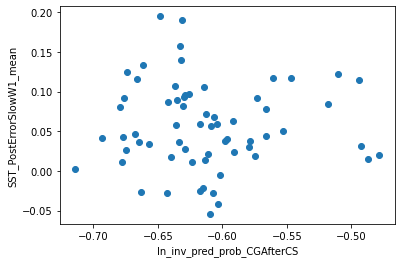

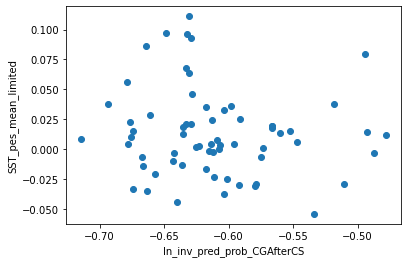

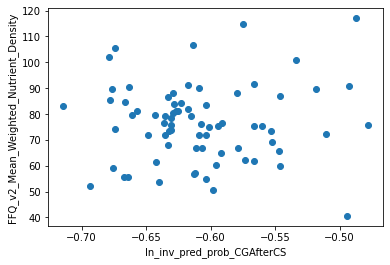

(0.5, 0.37037037037037035)


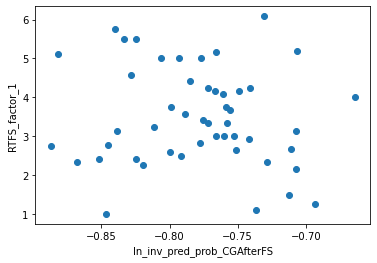

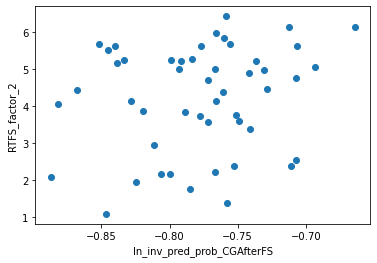

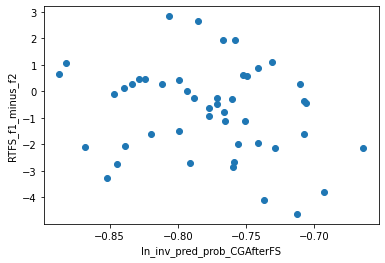

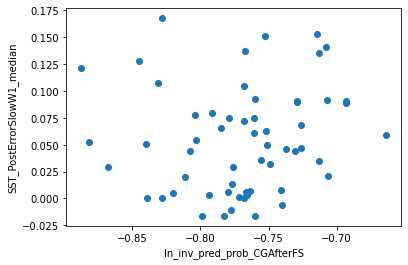

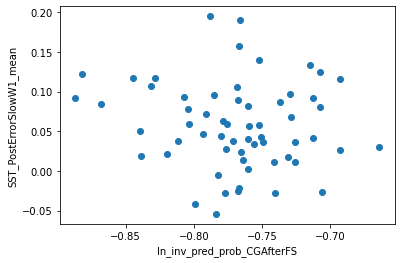

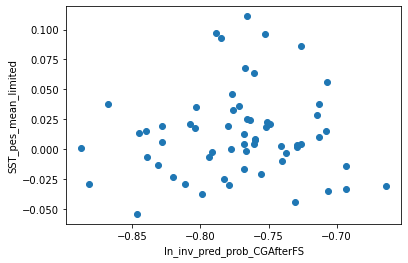

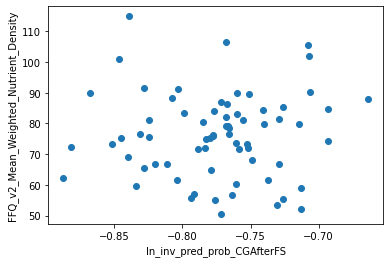

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_self referential_association-test_z_FDR_0.01.pkl
self referential_association-test_z_FDR_0.01
1752.2592592592594


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


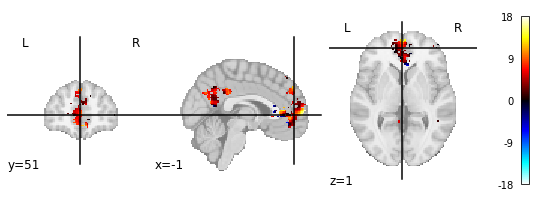

.................................................................................0.5 0.37037037037037035
(0.5, 0.37037037037037035)


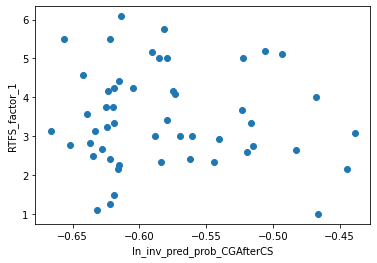

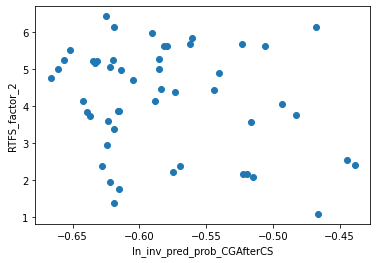

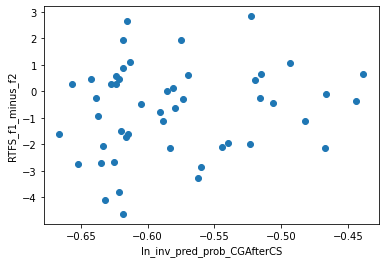

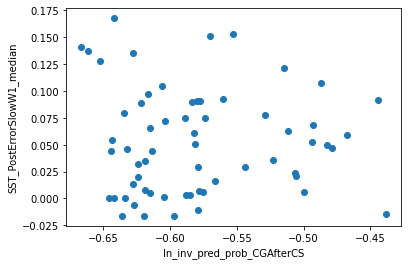

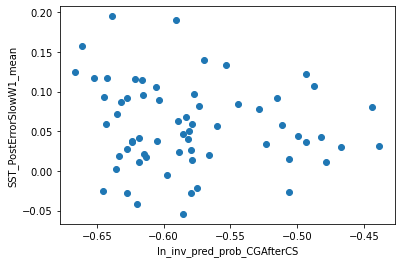

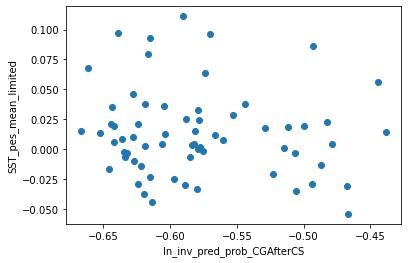

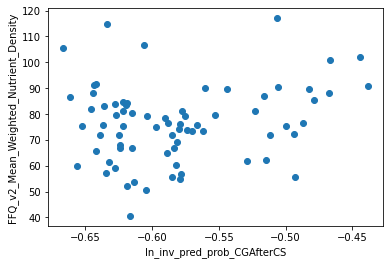

(0.5, 0.37037037037037035)


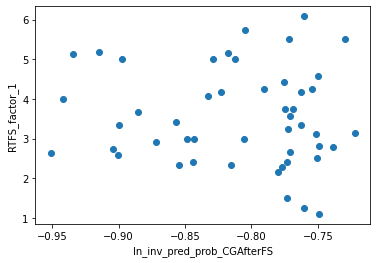

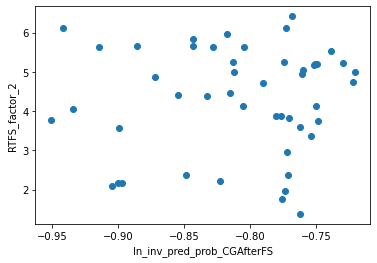

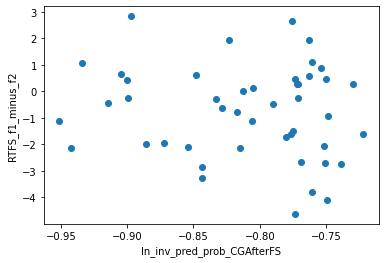

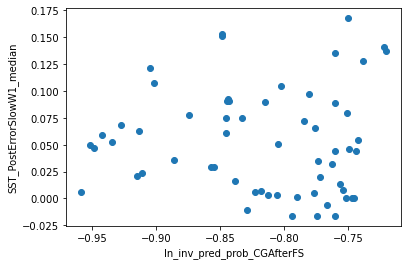

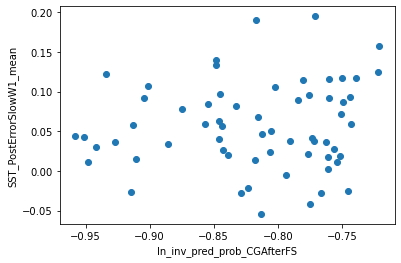

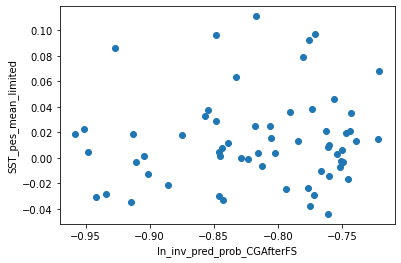

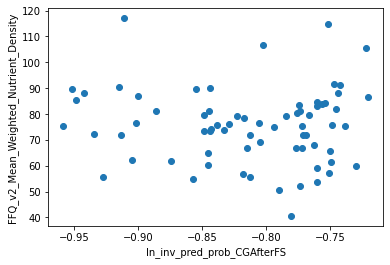

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl
harvardoxford-cortical_prob_Frontal Orbital Cortex
2879.141975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


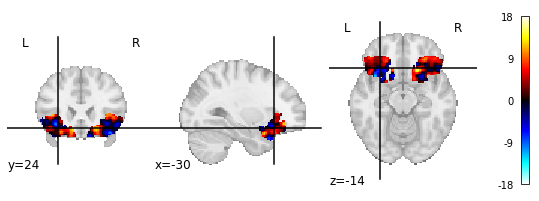

.................................................................................0.5123456790123457 0.2839506172839506
(0.5123456790123457, 0.2839506172839506)


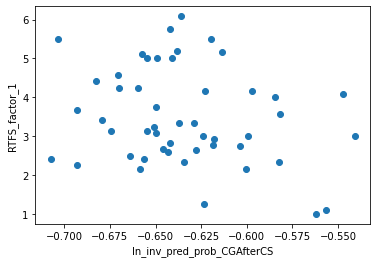

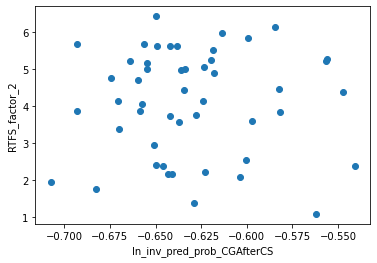

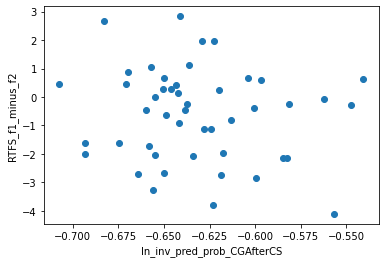

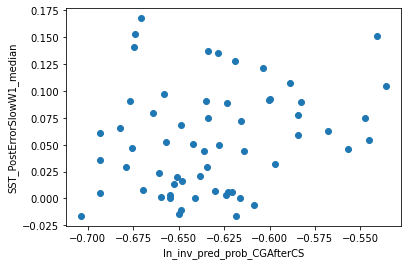

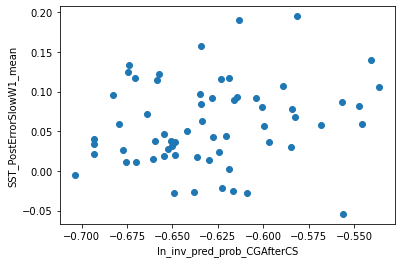

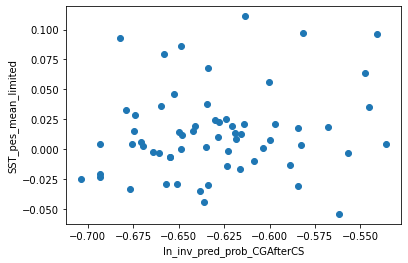

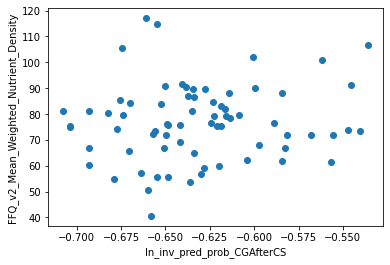

(0.5123456790123457, 0.2839506172839506)


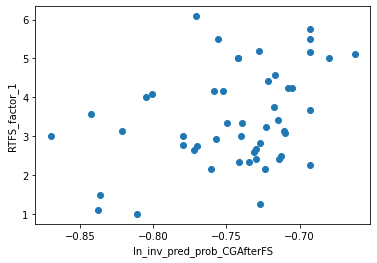

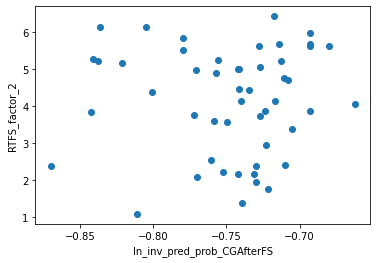

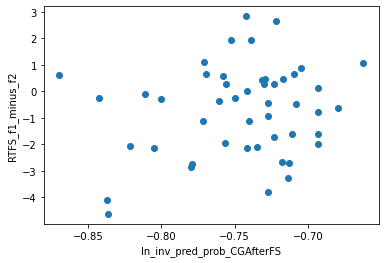

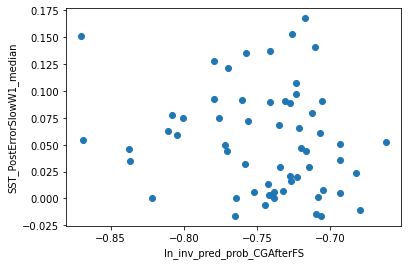

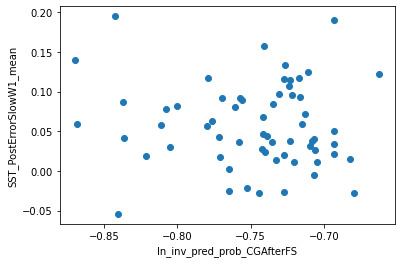

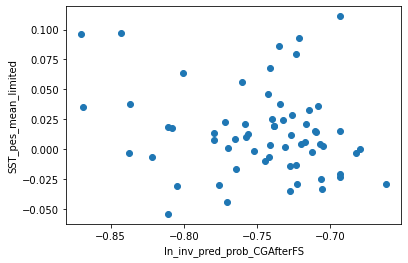

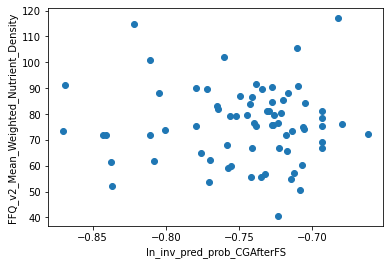

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.pkl
harvardoxford-cortical_prob_Cingulate Gyrus, anterior division
2791.222222222222


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


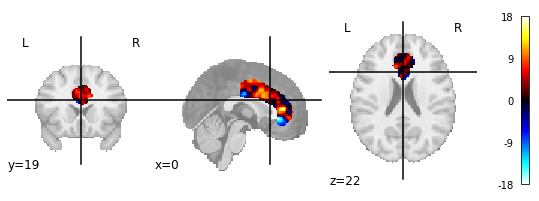

.................................................................................0.5 0.345679012345679
(0.5, 0.345679012345679)


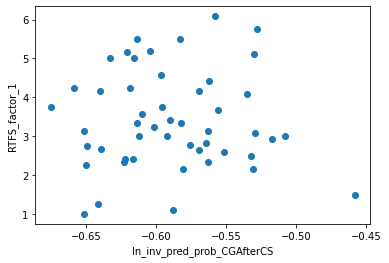

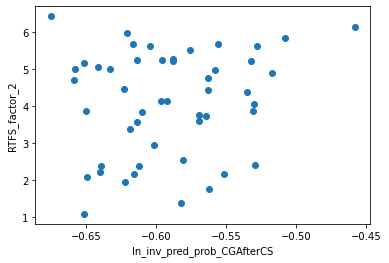

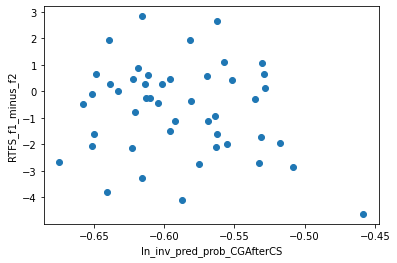

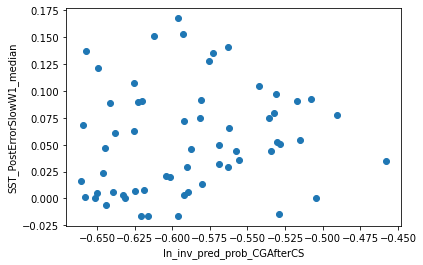

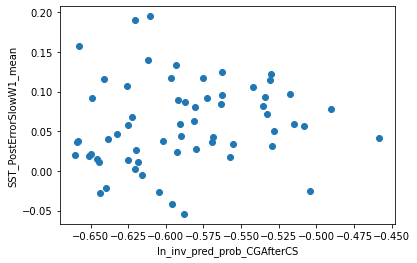

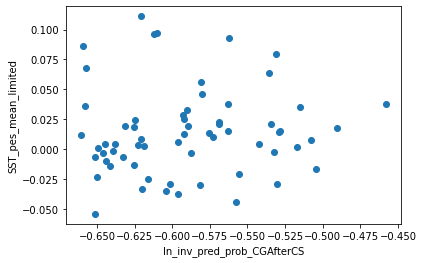

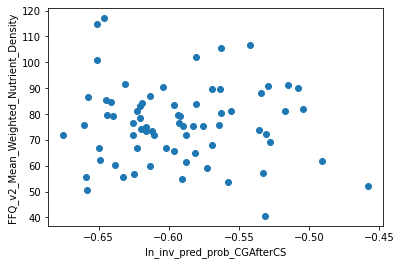

(0.5, 0.345679012345679)


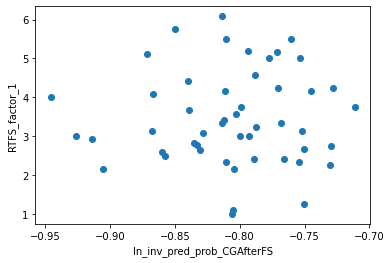

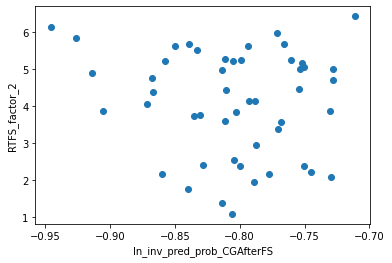

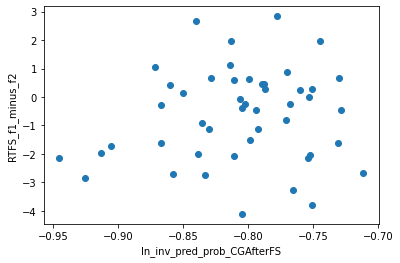

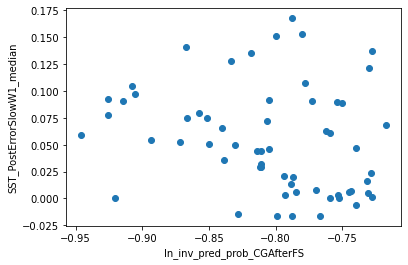

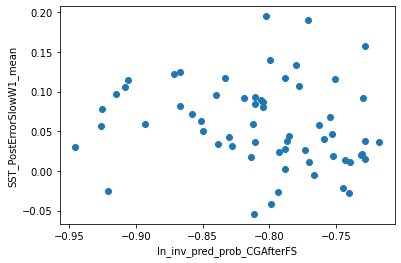

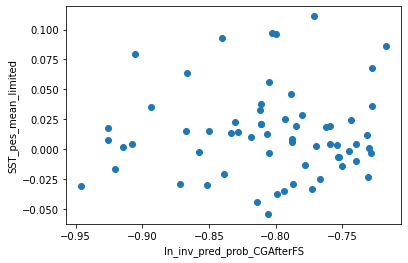

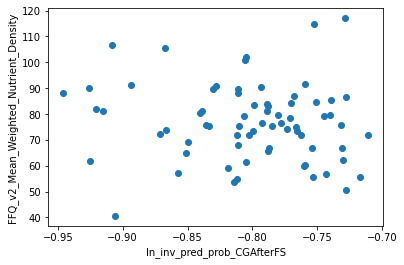

In [29]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" +
        mask_name
        + ".pkl"
    )
    print(brain_data_filepath)
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])

        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results

        
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CGAfterCS'],
            behavioral_measures = pes_vars_of_interest,
            target_y='CorrectGoFollowingCorrectStop')
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CGAfterFS'],
            behavioral_measures = pes_vars_of_interest,
            target_y='CorrectGoFollowingFailedStop')

In [30]:
pes_proba_masked = forced_choice_results_dict

In [31]:
def select_trials_by_type(df,trial_type):
    return(df[df['target_y']==trial_type])

def select_prob_col_with_label(df,prob_col):
    return(df.loc[:,['chunks',prob_col]])


# def select_CS_trials(df):
#     return(df[df['pred_y_forced_choice']=='CorrectStop'])

# def select_CS_and_labels(df):
#     return(df.loc[:,['chunks','pred_prob_CorrectStop']])

def label_cols(df, prepend):
    df1=df.copy()
    df1.columns = [prepend + c if c!="chunks" else c for c in df.columns]
    return(df1)


In [32]:
pes_proba_masked['harvardoxford-cortical_prob_Frontal Orbital Cortex']['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGoFollowingCorrectStop,pred_prob_CorrectGoFollowingFailedStop,ln_inv_pred_prob_CGAfterCS,ln_inv_pred_prob_CGAfterFS
0,DEV005_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.479206,0.520794,-0.652401,-0.735625
1,DEV005_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.476081,0.523919,-0.646418,-0.742167
0,DEV006_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.414901,0.585099,-0.535975,-0.879715
1,DEV006_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.414843,0.585157,-0.535875,-0.879855
0,DEV010_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.490349,0.509651,-0.674029,-0.712638
...,...,...,...,...,...,...,...,...
1,DEV216_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.482093,0.517907,-0.657960,-0.729618
0,DEV217_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.473232,0.526768,-0.640995,-0.748170
1,DEV217_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.476046,0.523954,-0.646351,-0.742241
0,DEV218_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,0.467025,0.532975,-0.629281,-0.761372


In [37]:
pes_proba_masked.keys()

dict_keys(['negative affect_association-test_z_FDR_0.01', 'emotion regulation_association-test_z_FDR_0.01', 'harvardoxford-cortical_prob_Frontal Medial Cortex', 'negative emotions_association-test_z_FDR_0.01', 'self referential_association-test_z_FDR_0.01', 'harvardoxford-cortical_prob_Frontal Orbital Cortex', 'harvardoxford-cortical_prob_Cingulate Gyrus, anterior division'])

In [38]:
CG_p_CS_wholebrain = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(SVC_proba_wholebrain['sample_wise'],'CorrectGoFollowingCorrectStop'),
    "pred_prob_CorrectGoFollowingCorrectStop"
),'CG_p_CS_wholebrain_')

CG_p_FS_wholebrain = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(SVC_proba_wholebrain['sample_wise'],'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_wholebrain_')

CG_p_FS_emotion_regulation = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(
        pes_proba_masked['emotion regulation_association-test_z_FDR_0.01']['sample_wise']
        ,'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_Frontal Orbital Cortex_')

CG_p_FS_Frontal_Orbital_Cortex = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(
        pes_proba_masked['harvardoxford-cortical_prob_Frontal Orbital Cortex']['sample_wise']
        ,'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_Frontal Orbital Cortex_')

# CG_p_CS_ACC = label_cols(
#     select_prob_col_with_label(
#     select_trials_by_type(
#         pes_proba_masked['harvardoxford-cortical_prob_Cingulate Gyrus, anterior division']['sample_wise']
#         ,'CorrectGoFollowingCorrectStop'),
#     "pred_prob_CorrectGoFollowingCorrectStop"
# ),'CG_p_CS_ACC_')

# CG_p_CS_Negative_Affect = label_cols(
#     select_prob_col_with_label(
#     select_trials_by_type(
#         pes_proba_masked['negative affect_association-test_z_FDR_0.01']['sample_wise']
#         ,'CorrectGoFollowingCorrectStop'),
#     "pred_prob_CorrectGoFollowingCorrectStop"
# ),'CG_p_CS_negative affect_')

In [39]:
neural_all = pd.merge(pd.merge(pd.merge(
        CG_p_CS_wholebrain,
        CG_p_FS_wholebrain),
        CG_p_FS_emotion_regulation),
        CG_p_FS_Frontal_Orbital_Cortex)

In [40]:
neural_behavioral = pd.merge(
    neural_all,
    individual_differences,
    left_on='chunks',right_on='subj_wave')



In [41]:
neural_behavioral.to_csv(ml_data_folderpath + "/analysis_v5_pes_test1.csv")